In [13]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [14]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [15]:
import numpy as np
import scipy.io as sio


class SVHN:

    def __init__(self, file_path, n_classes, use_extra=False, gray=False):
        self.n_classes = n_classes

        # # Load Train Set
        train = sio.loadmat(file_path + "/train_32x32.mat")
        self.train_labels = self.__one_hot_encode(train['y'])
        self.train_examples = train['X'].shape[3]
        self.train_data = self.__store_data(train['X'].astype("float32"), self.train_examples, gray)

        # Load Test Set
        test = sio.loadmat(file_path + "/test_32x32.mat")
        self.test_labels = self.__one_hot_encode(test['y'])
        self.test_examples = test['X'].shape[3]
        self.test_data = self.__store_data(test['X'].astype("float32"), self.test_examples, gray)

        # Load Extra dataset as additional training data if necessary
        if use_extra:
            extra = sio.loadmat(file_path + "/extra_32x32.mat")
            self.train_labels = np.append(self.train_labels, self.__one_hot_encode(extra['y']), axis=0)
            extra_examples = extra['X'].shape[3]
            self.train_examples += extra_examples
            self.train_data = np.append(self.train_data, self.__store_data(extra['X'].astype("float32"),
                                                                           extra_examples, gray), axis=0)
            # shuffle values
            idx = np.arange(self.train_data.shape[0])
            self.train_data = self.train_data[idx]
            self.train_labels = self.train_labels[idx]

    def __one_hot_encode(self, data):
        """Creates a one-hot encoding vector
            Args:
                data: The data to be converted
            Returns:
                An array of one-hot encoded items
        """
        n = data.shape[0]
        one_hot = np.zeros(shape=(data.shape[0], self.n_classes))
        for s in range(n):
            temp = np.zeros(self.n_classes)

            num = data[s][0]
            if num == 10:
                temp[0] = 1
            else:
                temp[num] = 1

            one_hot[s] = temp

        return one_hot

    def __store_data(self, data, num_of_examples, gray):
        d = []

        for i in range(num_of_examples):
            if gray:
                d.append(self.__rgb2gray(data[:, :, :, i]))
            else:
                d.append(data[:, :, :, i])

        return np.asarray(d)

    def __rgb2gray(self, rgb):
        return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype("float32")

(73257, 32, 32)
(73257, 32, 32, 1)
(26032, 32, 32, 1)
(26032, 10)


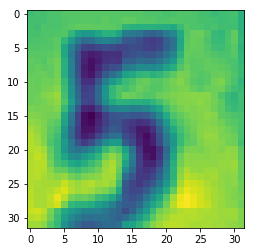

In [16]:
svhn = SVHN('svhn', 10, use_extra=False, gray=True)
print(svhn.train_data.shape)
image_size = 32
num_channels = 1
num_labels = 10
def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  #labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset

svhn.train_data = reformat(svhn.train_data, svhn.train_labels)
svhn.test_data = reformat(svhn.test_data, svhn.test_labels)
print(svhn.train_data.shape)
print(svhn.test_data.shape)
print(svhn.test_labels.shape)

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(svhn.test_data[0,:,:,0])
plt.show()


In [23]:
image_size = 32
num_channels = 1
num_labels = 10
num_test_samples = 10000

batch_size = 64
patch_size = 5
depth = 32
depth2 = 64
num_hidden = 128
num_hidden2 = 64
pool_size = 3
pool_stride = 2
padding = 'SAME'

image_size_after = image_size // 4

graph = tf.Graph()

with graph.as_default():
  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(svhn.test_data[:num_test_samples])
  tf_test_dataset = tf.constant(svhn.test_data[:num_test_samples])
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.01))
  layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth2], stddev=0.01))
  layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]))

  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size_after * image_size_after * depth2, num_hidden], stddev=0.01))
  layer3_biases = tf.Variable(tf.constant(0.5, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden2], stddev=0.01))
  layer4_biases = tf.Variable(tf.constant(0.5, shape=[num_hidden2]))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden2, num_labels], stddev=0.01))
  layer5_biases = tf.Variable(tf.constant(0.0, shape=[num_labels]))
 
  # Model.
  def model(data, keep_prob=1):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding=padding)
    hidden = tf.nn.relu(conv + layer1_biases)
    pool = tf.nn.max_pool(hidden, [1, pool_size, pool_size, 1],[1, pool_stride, pool_stride, 1], padding=padding)
    
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding=padding)
    hidden = tf.nn.relu(conv + layer2_biases)
    pool = tf.nn.max_pool(hidden,[1, pool_size, pool_size, 1],[1, pool_stride, pool_stride, 1], padding=padding)

    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    
    hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases), keep_prob)

    hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases), keep_prob)
    
    return tf.matmul(hidden, layer5_weights) + layer5_biases

  # Training computation.
  logits = model(tf_train_dataset, keep_prob=0.8)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

  # Optimizer.
  optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [24]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (svhn.train_labels.shape[0] - batch_size)
    batch_data = svhn.train_data[offset:(offset + batch_size), :, :, :]
    batch_labels = svhn.train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), svhn.test_labels[:num_test_samples]))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), svhn.test_labels[:num_test_samples]))


  W1 = layer1_weights.eval(session)
  B1 = layer1_biases.eval(session)
  W2 = layer2_weights.eval(session)
  B2 = layer2_biases.eval(session)
  W3 = layer3_weights.eval(session)
  B3 = layer3_biases.eval(session)
  W4 = layer4_weights.eval(session)
  B4 = layer4_biases.eval(session)
  W5 = layer5_weights.eval(session)
  B5 = layer5_biases.eval(session)
    
g = tf.Graph()
with g.as_default():

  input = tf.placeholder(tf.float32, shape=(1, image_size, image_size, num_channels), name="input")

  W1 = tf.constant(W1, name="W1")
  B1 = tf.constant(B1, name="B1")
  W2 = tf.constant(W2, name="W2")
  B2 = tf.constant(B2, name="B2")
  W3 = tf.constant(W3, name="W3")
  B3 = tf.constant(B3, name="B3")
  W4 = tf.constant(W4, name="W4")
  B4 = tf.constant(B4, name="B4")
  W5 = tf.constant(W5, name="W5")
  B5 = tf.constant(B5, name="B5")

  # Model.
  def model(data, keep_prob=1):
    conv = tf.nn.conv2d(data, W1, [1, 1, 1, 1], padding=padding)
    hidden = tf.nn.relu(conv + B1)
    pool = tf.nn.max_pool(hidden, [1, pool_size, pool_size, 1],[1, pool_stride, pool_stride, 1], padding=padding)
    
    conv = tf.nn.conv2d(pool, W2, [1, 1, 1, 1], padding=padding)
    hidden = tf.nn.relu(conv + B2)
    pool = tf.nn.max_pool(hidden,[1, pool_size, pool_size, 1],[1, pool_stride, pool_stride, 1], padding=padding)

    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    
    hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(reshape, W3) + B3), keep_prob)

    hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(hidden, W4) + B4), keep_prob)
    
    return tf.matmul(hidden, W5) + B5

  output = tf.nn.softmax(model(input), name="output")
    
  sess = tf.Session()
  init = tf.initialize_all_variables()
  sess.run(init)

  graph_def = g.as_graph_def()
  tf.train.write_graph(graph_def, '/tmp', '4_convolutions_model_graph.pb', as_text=False)


Initialized
Minibatch loss at step 0: 2.304611
Minibatch accuracy: 10.9%
Validation accuracy: 15.9%
Minibatch loss at step 50: 2.353894
Minibatch accuracy: 7.8%
Validation accuracy: 19.7%
Minibatch loss at step 100: 2.088325
Minibatch accuracy: 21.9%
Validation accuracy: 21.1%
Minibatch loss at step 150: 1.976367
Minibatch accuracy: 31.2%
Validation accuracy: 32.2%
Minibatch loss at step 200: 1.911067
Minibatch accuracy: 40.6%
Validation accuracy: 40.2%
Minibatch loss at step 250: 1.696423
Minibatch accuracy: 43.8%
Validation accuracy: 51.4%
Minibatch loss at step 300: 1.263157
Minibatch accuracy: 57.8%
Validation accuracy: 56.7%
Minibatch loss at step 350: 1.060448
Minibatch accuracy: 64.1%
Validation accuracy: 62.7%
Minibatch loss at step 400: 1.236989
Minibatch accuracy: 51.6%
Validation accuracy: 65.5%
Minibatch loss at step 450: 1.103319
Minibatch accuracy: 57.8%
Validation accuracy: 68.3%
Minibatch loss at step 500: 1.040842
Minibatch accuracy: 65.6%
Validation accuracy: 70.5%
Mi